# Notebook used to scrape and analyse data from the VOAT social network

In [2]:
from bs4 import BeautifulSoup as bs
import requests
from requests import ReadTimeout, ConnectTimeout, HTTPError, Timeout, ConnectionError
import json
import importlib
import voatScraper
from datetime import datetime
import praw, tweepy
from psaw import PushshiftAPI
import pandas as pd
import os
import expressvpn
from collections import Counter
import time
import networkx as nx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

#### Twitter, Reddit API and Voat Setup

In [2]:
with open("../Credentials/redditCredentials.json", "r") as redditFile:
    redditCredentials = json.load(redditFile)

In [3]:
reddit = praw.Reddit(client_id=redditCredentials['client_id'], \
                     client_secret=redditCredentials['client_secret'], \
                     user_agent='test', \
                     username=redditCredentials['username'], \
                     password=redditCredentials['password'])

psawAPI = PushshiftAPI(reddit)

In [4]:
with open("../Credentials/twitterCredentials.json", "r") as twitterFile:
    twitterCredentials = json.load(twitterFile)

In [5]:
with open("../Credentials/voatCredentials.json", "r") as voatFile:
    voatCredentials = json.load(voatFile)

In [6]:
auth = tweepy.OAuthHandler(twitterCredentials['consumer_key'], twitterCredentials['consumer_secret'])
auth.set_access_token(twitterCredentials['access_key'], twitterCredentials['access_secret'])
twitterAPI = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

### VOAT Communites Scraping

In [ ]:
importlib.reload(voatScraper)
communityDF = voatScraper.voat_community_analysis(voatCredentials=voatCredentials)

In [ ]:
importlib.reload(voatScraper)
communityList = ['Conspiracy', 'theawakening', 'pizzagate', 'GreatAwakening', 'TheDonald', 'theunexplained', 'conspiracyfact',
                 'TheGreatAwakening', 'GamerGate', 'trueconspiracies', 'Identitarian', 'UFO', 'PatriotsSoapbox', 'UnderReported', 'QAnon', 'preppers',
                 'classic4chan', 'pizzagatewhatever', 'UncensoredMedicine', '911Truth', 'CalmBeforeTheStorm', 'QAwakening', 'Paranormal', 'Censorship',
                 'pizzagateunedited', 'pizzagateuncensored', 'NSA', 'actualconspiracies', 'RealConspiracy', 'QProofs', 'altnews']
communityList = ['CalmBeforeTheStorm', 'Conspiracy', 'theawakening', 'pizzagate', 'TheDonald', 'TheGreatAwakening', 'UncensoredMedicine', '911Truth',
                 'preppers', 'altnews']
subsDF, commsDF = voatScraper.voat_data_scraping(twitterAPI=twitterAPI, voatCredentials=voatCredentials, communityList=communityList, psawAPI=psawAPI,
                                                 querySource='twitter.com', commentsAnalysis=True, userAnalysis=True)

In [8]:
subsDF = subsDF.sort_values(by='username', ignore_index=True)

In [10]:
subsDF.to_csv('twitterSubs.csv')

In [11]:
commsDF.to_csv('twitterComms.csv')

### Subverse Wordclouds

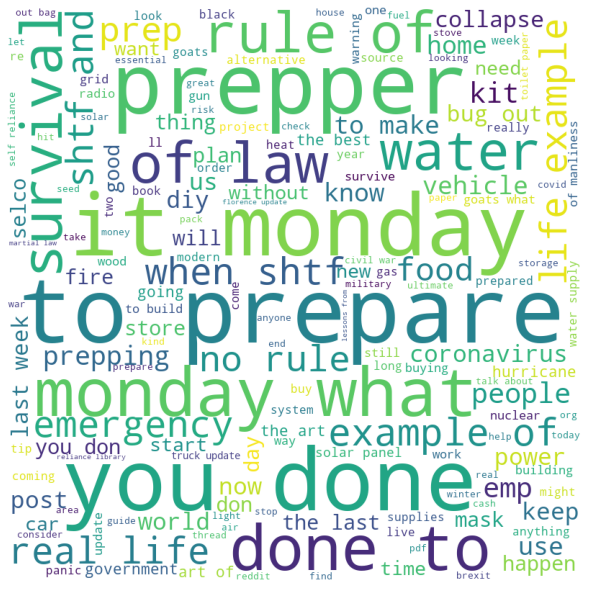

In [10]:
importlib.reload(voatScraper)
voatScraper.subverse_wordcloud(voatCredentials=voatCredentials, subverse='preppers')

### VOAT History Analysis

In [ ]:
importlib.reload(voatScraper)
submissionDF = voatScraper.voat_history_query(voatCredentials, queryWordList=['flynn'], dateBeginning='2019-09-01', dateEnd='2020-05-17', nsfw='on')

In [8]:
submissionDF = submissionDF.sort_values(by='link_root', ignore_index=True)

In [9]:
submissionDF.to_csv('Search Queries/flynn.csv')

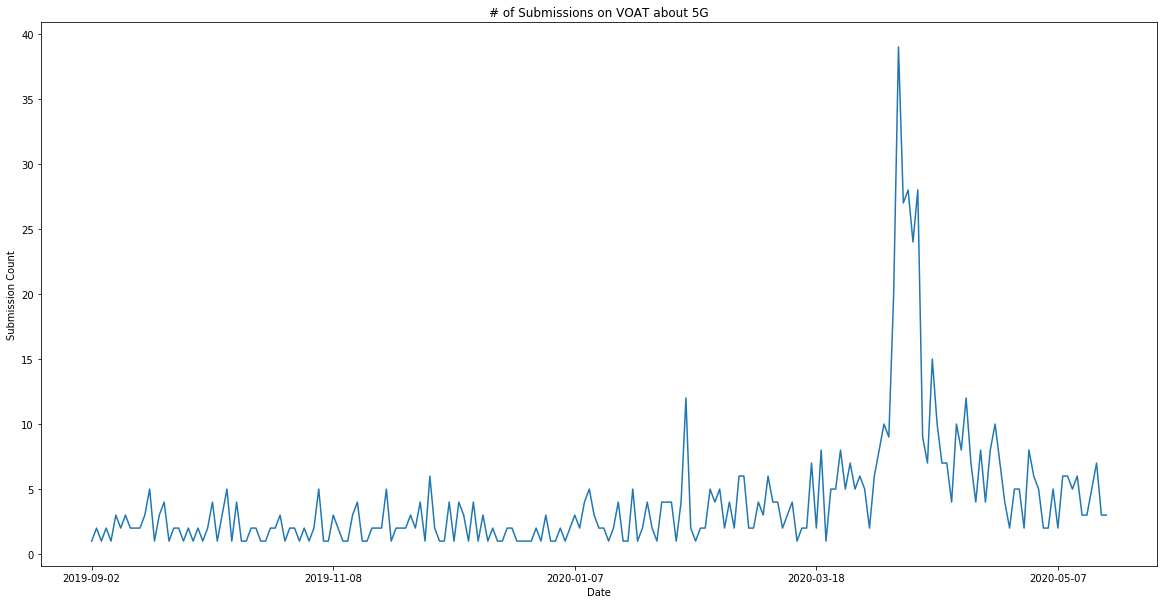

In [40]:
importlib.reload(voatScraper)
voatScraper.conspiracy_time_analysis(submissionDF, '5G')

In [9]:
submissionDF.drop_duplicates(ignore_index=True).to_csv('Search Queries/flynn.csv')

### VOAT Users Analysis

#### Bill Gates

In [3]:
voatUsers = list(set(list(pd.read_csv('Search Queries/billgates.csv').author.values)))
voatUsers.extend(list(set(list(pd.read_csv('Search Queries/5g.csv').author.values))))
voatUsers.extend(list(set(list(pd.read_csv('Search Queries/flynn.csv').author.values))))

voatUsers = list(set(voatUsers))

In [ ]:
voatNetwork = voatScraper.voat_user_activity(voatUsers, psawAPI)

In [27]:
edgesWeights = [edge[2]['weight'] for edge in voatNetwork.edges(data=True)]
avgWeight = np.mean(edgesWeights)
filteredEdges = [edge for edge in voatNetwork.edges(data=True) if edge[2]['weight'] < avgWeight]
voatNetwork.remove_edges_from(filteredEdges)

In [29]:
nodesFiltered = [node for (node, degree) in voatNetwork.degree if degree == 0]
voatNetwork.remove_nodes_from(nodesFiltered)

In [31]:
nx.write_gexf(voatNetwork, 'Gephi Files/voatNetworkJune.gexf')

In [ ]:
billGatesUsers = list(set(list(pd.read_csv('Search Queries/billgates.csv').author.values)))
gatesNetwork = voatScraper.voat_user_activity(billGatesUsers, psawAPI)


In [13]:
filteredEdges = [edge for edge in gatesNetwork.edges(data=True) if edge[2]['weight'] < 2]
gatesNetwork.remove_edges_from(filteredEdges)
    
nodesFiltered = [node for (node, degree) in gatesNetwork.degree if degree == 0]
gatesNetwork.remove_nodes_from(nodesFiltered)

In [17]:
nx.write_gexf(gatesNetwork, 'Gephi Files/gatesNetwork.gexf')

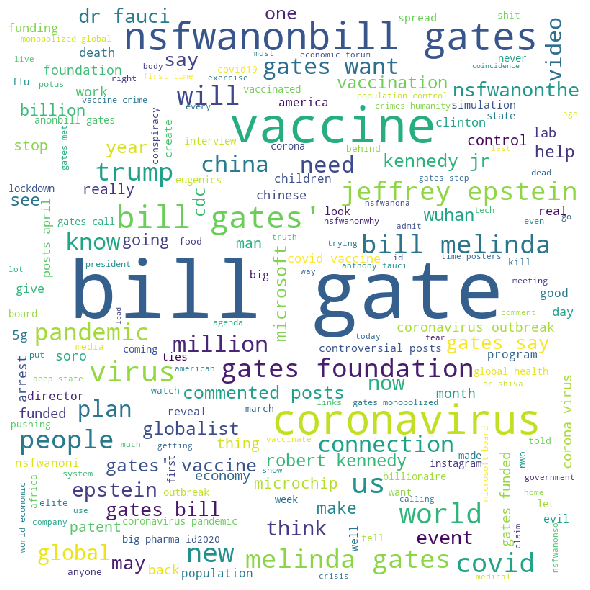

In [21]:
importlib.reload(voatScraper)
voatScraper.topic_wordcloud('billgates')

#### Plandemic

In [ ]:
plandemicUsers = list(set(list(pd.read_csv('Search Queries/plandemic.csv').author.values)))
plandemicNetwork = voatScraper.voat_user_activity(plandemicUsers, psawAPI)

In [10]:
nx.write_gexf(plandemicNetwork, 'Gephi Files/plandemicNetwork.gexf')

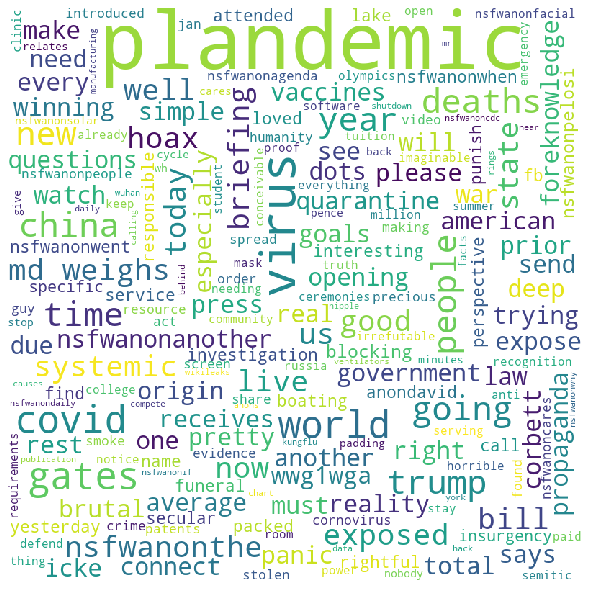

In [23]:
importlib.reload(voatScraper)
voatScraper.topic_wordcloud('plandemic')

#### 5G

In [ ]:
fiveGUsers = list(set(list(pd.read_csv('Search Queries/5g.csv').author.values)))
fiveGNetwork = voatScraper.voat_user_activity(fiveGUsers, psawAPI)

In [14]:
filteredEdges = [edge for edge in fiveGNetwork.edges(data=True) if edge[2]['weight'] < 2]
fiveGNetwork.remove_edges_from(filteredEdges)
    
nodesFiltered = [node for (node, degree) in fiveGNetwork.degree if degree == 0]
fiveGNetwork.remove_nodes_from(nodesFiltered)

In [17]:
nx.write_gexf(fiveGNetwork, 'Gephi Files/fiveGNetwork.gexf')

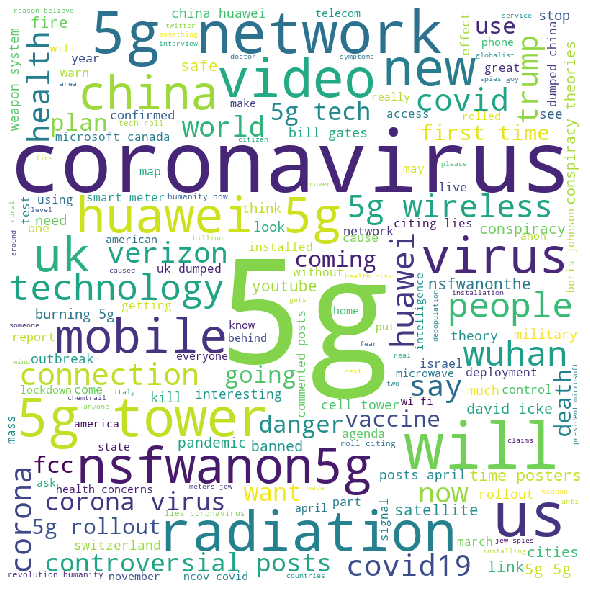

In [22]:
importlib.reload(voatScraper)
voatScraper.topic_wordcloud('5g')

#### Flynn

In [20]:
flynnUsers = list(set(list(pd.read_csv('Search Queries/flynn.csv').author.values)))
flynnNetwork = voatScraper.voat_user_activity(flynnUsers, psawAPI)

--- Starting User Analysis


In [11]:
flynnDF = pd.read_csv('Search Queries/plandemic.csv')
voatScraper.twitter_query_analysis(flynnDF, 'plandemic', twitterAPI)

In [24]:
filteredEdges = [edge for edge in flynnNetwork.edges(data=True) if edge[2]['weight'] < 2]
flynnNetwork.remove_edges_from(filteredEdges)
    
nodesFiltered = [node for (node, degree) in flynnNetwork.degree if degree == 0]
flynnNetwork.remove_nodes_from(nodesFiltered)

In [25]:
nx.write_gexf(fiveGNetwork, 'Gephi Files/flynnNetwork.gexf')

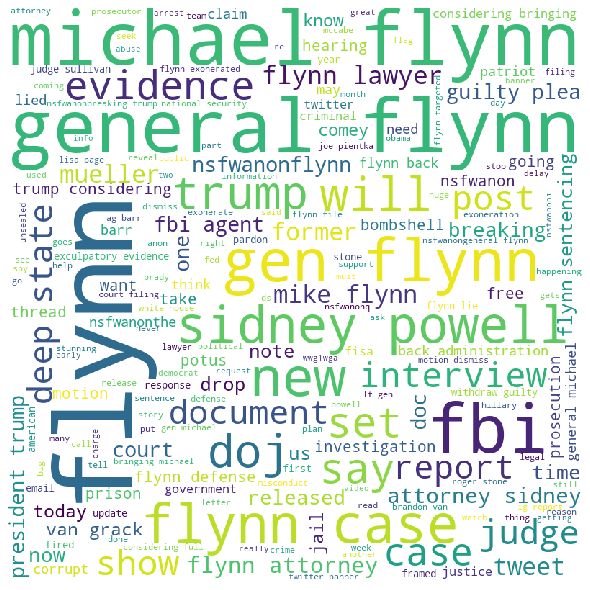

In [24]:
importlib.reload(voatScraper)
voatScraper.topic_wordcloud('flynn')

#### Networks Comparison

In [8]:
gatesNetwork  = nx.read_gexf('Gephi Files/gatesNetwork.gexf')
plandemicNetwork  = nx.read_gexf('Gephi Files/plandemicNetwork.gexf')
fiveGNetwork  = nx.read_gexf('Gephi Files/fiveGNetwork.gexf')
flynnNetwork = nx.read_gexf('Gephi Files/flynnNetwork.gexf')

In [14]:
commonSubreddits = list(set(set(set(list(gatesNetwork.nodes())).intersection(list(plandemicNetwork.nodes()))).intersection(list(fiveGNetwork.nodes()))).intersection(list(flynnNetwork.nodes())))

In [33]:
submissionDict = [{'subreddit': subreddit, 'gates': gatesNetwork.nodes[subreddit]['submission_count'], 
                                           'plandemic': plandemicNetwork.nodes[subreddit]['submission_count'],
                                           '5g': fiveGNetwork.nodes[subreddit]['submission_count'],
                                           'flynn': flynnNetwork.nodes[subreddit]['submission_count']} for subreddit in commonSubreddits]

commentDict = [{'subreddit': subreddit, 'gates': gatesNetwork.nodes[subreddit]['comment_count'], 
                                        'plandemic': plandemicNetwork.nodes[subreddit]['comment_count'],
                                        '5g': fiveGNetwork.nodes[subreddit]['comment_count'],
                                        'flynn': flynnNetwork.nodes[subreddit]['comment_count']} for subreddit in commonSubreddits]

commonSubDF = pd.DataFrame(submissionDict)
commonCommDF = pd.DataFrame(commentDict)
commonSubDF.to_csv('commonSubDF.csv')
commonCommDF.to_csv('commonCommDF.csv')

In [19]:
bill = pd.read_csv('VOAT Results/billGatesReddit.csv', usecols=['Id', '0', '1'])
bill.columns = ['subreddit', '# submissions', '# comments']
bill = bill.sort_values(by='# submissions', ascending=False, ignore_index=True)

In [21]:
bill.to_csv('VOAT Results/billGatesReddit.csv')

### Geographical Data Analysis

In [ ]:
importlib.reload(voatScraper)
worldDF = voatScraper.country_subverse_extraction(voatCredentials)
worldDF.to_csv('worldDF.csv')

In [9]:
countryInfo = pd.read_csv('../Geographic Data/countryInfo.txt', sep="	", header=None, usecols=[4, 5, 9]).dropna()
countryInfo.columns = ['country', 'capital', 'domain']

worldDF = pd.read_csv('worldDF.csv')
worldDF = worldDF[worldDF.country != 'Georgia']

In [ ]:
importlib.reload(voatScraper)
voatScraper.country_subverse_plot(worldDF)

### USA Data Analysis

In [ ]:
importlib.reload(voatScraper)
statesDF = voatScraper.us_subverse_extraction(voatCredentials)
statesDF.subscribers = pd.to_numeric(statesDF.subscribers)

In [ ]:
importlib.reload(voatScraper)
voatScraper.us_subverse_plot(statesDF)

### User Hierarchy Analysis

In [ ]:
importlib.reload(voatScraper)
submissionDF = voatScraper.voat_hierarchy_analysis(voatCredentials=voatCredentials, subverseList=['science'])

### Subverses Intersection Analysis

In [ ]:
importlib.reload(voatScraper)
subverseGraph = voatScraper.subverse_intersection_analysis(voatCredentials, startDate='2020-05-01', stopDate='2020-05-15')

In [11]:
nx.write_gexf(subverseGraph, 'Subverse Intersection/subverseGraph.gexf')

### Twitter Posts Retrieval

In [ ]:
importlib.reload(voatScraper)
twitterDF = voatScraper.twitter_posts_retrieval(voatCredentials=voatCredentials, dateBeginning='2020-01-01', dateEnd='2020-01-31', twitterAPI=twitterAPI)

In [8]:
twitterDF.to_csv('Twitter Analysis/voat6.csv')

## Twitter Network Creation

In [7]:
importlib.reload(voatScraper)
commonAuthorsDF = voatScraper.seed_selection()

In [8]:
commonAuthorsDF.author.values[0:10]

array(['realDonaldTrump', 'bennyjohnson', 'AltviewIreland',
       'RealJamesWoods', 'Inevitable_ET', 'KarluskaP', 'M2Madness',
       'cjtruth', 'LisaMei62', 'thehill'], dtype=object)

In [9]:
commonAuthorsDF.to_csv('Twitter Analysis/commonAuthorsDF.csv')
commonAuthorsDF.to_excel('Twitter Analysis/commonAuthorsDF.xlsx')

In [ ]:
importlib.reload(voatScraper)
twitterNetwork, totalMentionDF = voatScraper.twitter_network_creation(twitterAPI, seedList=list(commonAuthorsDF.author.values)[0:10])

In [12]:
nx.write_gexf(twitterNetwork, 'Twitter Networks/voat.gexf')

### Networks Analysis

In [7]:
voatNetwork = nx.read_gexf('Twitter Networks/voat.gexf')

In [9]:
importlib.reload(voatScraper)
voatBetweennessList, qAnonBetweennessList = voatScraper.voat_network_analysis()

## Voat Hashtags Retrieval

In [24]:
importlib.reload(voatScraper)
voatHashtags = voatScraper.hashtags_retrieval()

## Voat Interactions Analysis

In [ ]:
importlib.reload(voatScraper)
submissionDF, commentDF = voatScraper.voat_history_query(voatCredentials, queryWordList=['coronavirus'], dateBeginning='2020-03-01', 
                                                                      dateEnd='2020-03-12', nsfw='on', commentsAnalysis=True)

In [11]:
commentDF.to_csv('Comments Analysis/coronavirus31.csv')
submissionDF.to_csv('Comments Analysis/coronavirusSub31.csv')

In [16]:
importlib.reload(voatScraper)
voatNetwork, subverseCountList = voatScraper.voat_network_creation()

4879 21478
1304 3598


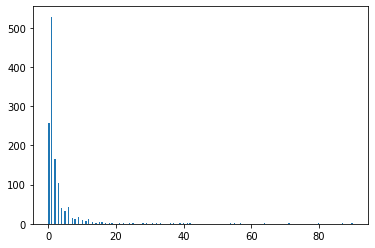

In [25]:
countListFiltered = [count for count in subverseCountList if count < 240]
plt.hist(countListFiltered, bins='auto')
plt.savefig('Comments Analysis/subverseHist.png')

In [14]:
nx.write_gexf(voatNetwork, 'Comments Analysis/commentsNetwork.gexf')

### Network Analysis

In [7]:
voatNetwork = nx.read_gexf('Comments Analysis/commentsNetwork.gexf')
voatBetweennessList = voatScraper.betweenness_computation(voatNetwork)

In [8]:
importlib.reload(voatScraper)
voatCiRanking = voatScraper.collective_influence_computation(voatNetwork, distance=2, rankingLength=20)

In [9]:
twitterNetwork = nx.read_gexf('Twitter Networks/voat.gexf')
twitterBetweennessList = voatScraper.betweenness_computation(twitterNetwork)

In [10]:
importlib.reload(voatScraper)
twitterCiRanking = voatScraper.collective_influence_computation(twitterNetwork, distance=2, rankingLength=20)

In [12]:
voatCiRanking

['LakotaPride',
 'rickki6',
 'quantum1234',
 'Sheeitpost',
 'Lurker17',
 'HarlandKornfeld14',
 'Wiserman',
 'Mustard_Monkey',
 'blackguard19',
 'waldo1899',
 'HappyMealBullshit',
 'PhilKDick',
 'Alderwolf',
 'Roughpatch',
 'TSE',
 'Carsandsarcasm',
 'Snuffy_5_Smith',
 'KosherHiveKicker',
 'cabalstone',
 'carnold03']